## **SML 301: Final Project**

## **Introduction**

In this project we are interested in building a model that predicts the types of animals and the number of animals shown on images in the *Wild* dataset.  We will deviate from the approach used by [Parham et al.](https://ieeexplore.ieee.org/document/8354227) (the paper that we read in Precept 8) and employ a less complicated method inspired by the one used in [*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui instead.

Machine learning is a rapidly evolving field. Thus, part of the requirement of being a successful machine learning data scientist is to keep up with the state of the art machine learning techniques in the research literature. Part of the goal of this project is for us to practice  doing independent research. In some parts of this project, we read material on a topic that were are not totally familiar and apply the techniques that we learned from the reading.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import os, sys
import re
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, utils
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import pickle

The unique names of the animals of interest are stored in the list reduced_classes below. For each image, our goal is to identify the animals shown on the image and count how many there are.

In [3]:
# Animal species classes
reduced_classes = ['giraffe_reticulated','zebra_grevys','turtle_sea',
                  'zebra_plains','giraffe_masai', 'whale_fluke']

# Path name for annotations
annotations_path = '/content/drive/MyDrive/Old school work/SML 301/wild/Annotations'
class_annotations_path = '/content/drive/MyDrive/Old school work/SML 301/wild/class_annotations'
count_annotations_path = '/content/drive/MyDrive/Old school work/SML 301/wild/count_annotations'
jpeg_path = '/content/drive/MyDrive/Old school work/SML 301/wild/JPEGImages'

We now redo steps from Precept 10 to remove duplicates and generate folders of classification annotations and count annotations.

In [4]:
# Get all file names
all_files = os.listdir(annotations_path)

In [5]:
# Check that all files were correctly uploaded to Google Drive with no duplicates
len(all_files)

5794

We found that some files were duplicated with an extra parantheses and version number appended to the file name when uploaded to Google Drive.

In [6]:
# Remove duplicates
file_names = []
index = 0
for i in range(0, len(all_files)):
  if (all_files[i].find("(") == -1):
    file_names.append(all_files[i])

# check how many files now
len(file_names)

5784

First generate the classification annotations (commented out because the files only need to be created once).

In [13]:
# go through each xml file
# for i in range(0, len(file_names)):

  # read the xml file
  # with open(annotations_path + "/" + file_names[i], 'r') as f:
    # file = f.read()
  # soup = BeautifulSoup(file, 'xml')

  # create classify_arr
  # classify_arr = np.zeros(len(reduced_classes))

  # get all animals in the xml file
  # animals = soup.find_all('name')

  # go through each animal
  # for j in range(0, len(animals)):

    # mark it off as 1 in the classify_arr
    # if animals[j].text in reduced_classes:
      # index = reduced_classes.index(animals[j].text)
      # classify_arr[index] = 1

  # save the filled in classify_arr to class_annotations
  # np.save(class_annotations_path + "/" + file_names[i][:-3] + "npy", classify_arr)


Next generate the count annotations (commented out because the files only need to be created once).

In [15]:
# go through each xml file
# for i in range(0, len(file_names)):

  # read the xml file
  # with open(annotations_path + "/" + file_names[i], 'r') as f:
    # file = f.read()
  # soup = BeautifulSoup(file, 'xml')

  # create count_arr
  # count_arr = np.zeros(len(reduced_classes))

  # get all animals in the xml file
  # animals = soup.find_all('name')

  # go through each animal
  # for j in range(0, len(animals)):

    # add 1 in the count_arr
    # if animals[j].text in reduced_classes:
      # index = reduced_classes.index(animals[j].text)
      # count_arr[index] += 1

  # save the filled in count_arr to class_annotations
  # np.save(count_annotations_path + "/" + file_names[i][:-3] + "npy", count_arr)


## **Question 1. Data quality check and EDA**

### Part a

We verifed we had 5,784 files in each of the *class_annotations* and *count_annotations* folders. This number should match the how many files were in the original *Annotations* folder.

In [7]:
# Count files in class_annotations
class_files = os.listdir(class_annotations_path)
len(class_files)

5784

In [8]:
# Count files in count_annotations
count_files = os.listdir(count_annotations_path)
len(count_files)

5784

### Part b

Next, we examed a subset of the data.

In [9]:
# Names of the files we will use for inspection
file_names_subset = ['2018_002805.npy', '2018_000974.npy', '2018_000960.npy', '2018_002811.npy', '2018_004290.npy',
                    '2018_002839.npy', '2018_003299.npy', '2018_002187.npy', '2018_000948.npy', '2018_000790.npy',
                    '2018_001483.npy', '2018_000789.npy', '2018_000951.npy', '2018_001497.npy', '2018_003280.npy']

In [10]:
# Print class annotations for files in the subset
for file in file_names_subset:
    print(np.load(class_annotations_path + '/' + file))

[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]


*Our outputs for `classify_arr` match the following which were given.*

```python
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

In [11]:
# Print count annotations for files in the subset
for file in file_names_subset:
    print(np.load(count_annotations_path + '/' + file))

[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]


*Our outputs for `count_arr` match the following which were given.*

```python
[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

### Part c

We sought to examine our data more closely, particularly with regards to the frequency of animal occurrences in the images.

To achieve this, we conducted a detailed analysis and generated a range of informative histograms.

#### Answers

**(i.) The minimum number of animals in an image is 1 and the maximum is 22.**

In [12]:
# Minimum and maximum number of animals in an image
animal_counts = []

for count_file in count_files:
    count_arr = np.load(os.path.join(count_annotations_path, count_file))
    total_animals = int(np.sum(count_arr))
    animal_counts.append(total_animals)

min_animals = min(animal_counts)
max_animals = max(animal_counts)

print(f"Minimum number of animals in an image: {min_animals}")
print(f"Maximum number of animals in an image: {max_animals}")

Minimum number of animals in an image: 1
Maximum number of animals in an image: 22


**(ii) Histogram for the number of animals in an image**

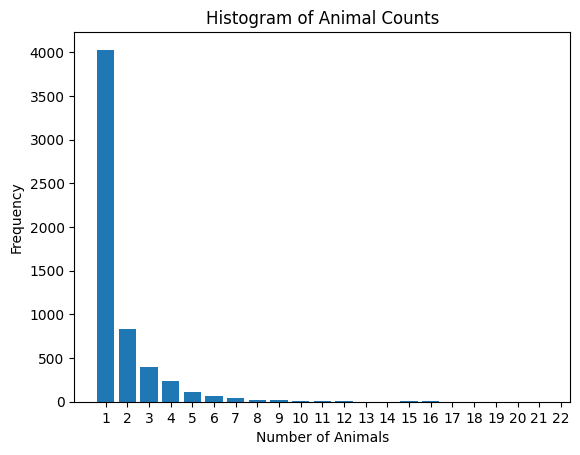

In [13]:
# Histogram for the number of animals in an image
plt.hist(animal_counts, bins=range(min_animals, max_animals + 1), align='left', rwidth=0.8)
plt.xlabel('Number of Animals')
plt.ylabel('Frequency')
plt.title('Histogram of Animal Counts')
plt.xticks(range(min_animals, max_animals + 1))
plt.show()

**(iii.)
The distribution has a long right tail. To determine this, we can visually examined the histogram generated above. Additionally, the mean and median are often used as measures of central tendency to describe the distribution of a dataset, we calculated the mean (1.71) and median (1.0). This further confirmed that our data was not symmetric and was right-skewed.**

In [14]:
# Mean and median of animal counts
mean_animal_count = np.mean(animal_counts)
median_animal_count = np.median(animal_counts)

print(f"Mean: {mean_animal_count}")
print(f"Median: {median_animal_count}")

Mean: 1.7066044260027662
Median: 1.0


### Part d

Next, we created a histogram for each of the six animal species that showed the number of animals that appeared in each image.

Instead of creating six separate histograms, we created one histogram with stacked bins to allow for easier comparison across the different categories.

In [15]:
# Get the counts of each species
species_counts = {animal_class: [] for animal_class in reduced_classes}

for count_file in count_files:
    count_arr = np.load(os.path.join(count_annotations_path, count_file))
    for idx, animal_class in enumerate(reduced_classes):
        species_counts[animal_class].append(count_arr[idx])

**Histogram with stacked bins**

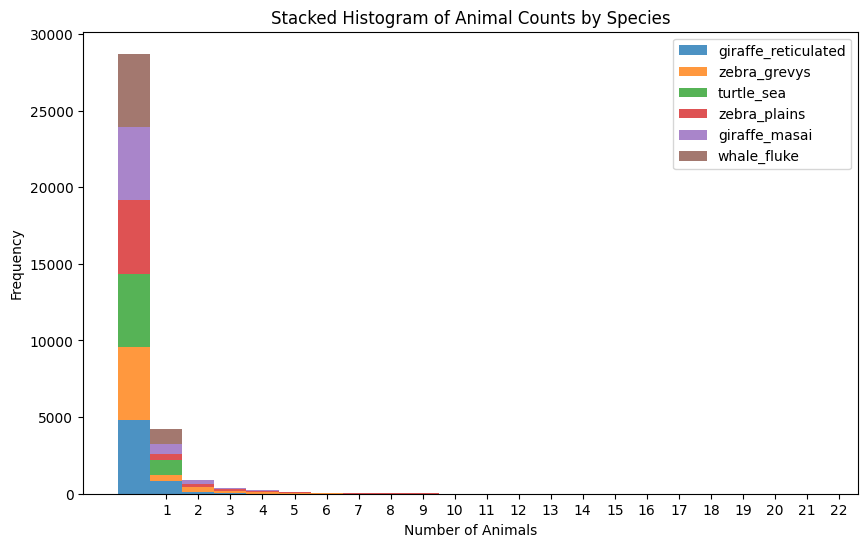

In [16]:
bins = np.arange(0, max_animals + 1) - 0.5
plt.figure(figsize=(10, 6))

# Prepare the data for stacked histogram
hist_data = [species_counts[animal_class] for animal_class in reduced_classes]
plt.hist(hist_data, bins=bins, alpha=0.8, label=reduced_classes, stacked=True)

plt.xlabel('Number of Animals')
plt.ylabel('Frequency')
plt.title('Stacked Histogram of Animal Counts by Species')
plt.legend()
plt.xticks(range(min_animals, max_animals + 1))
plt.show()

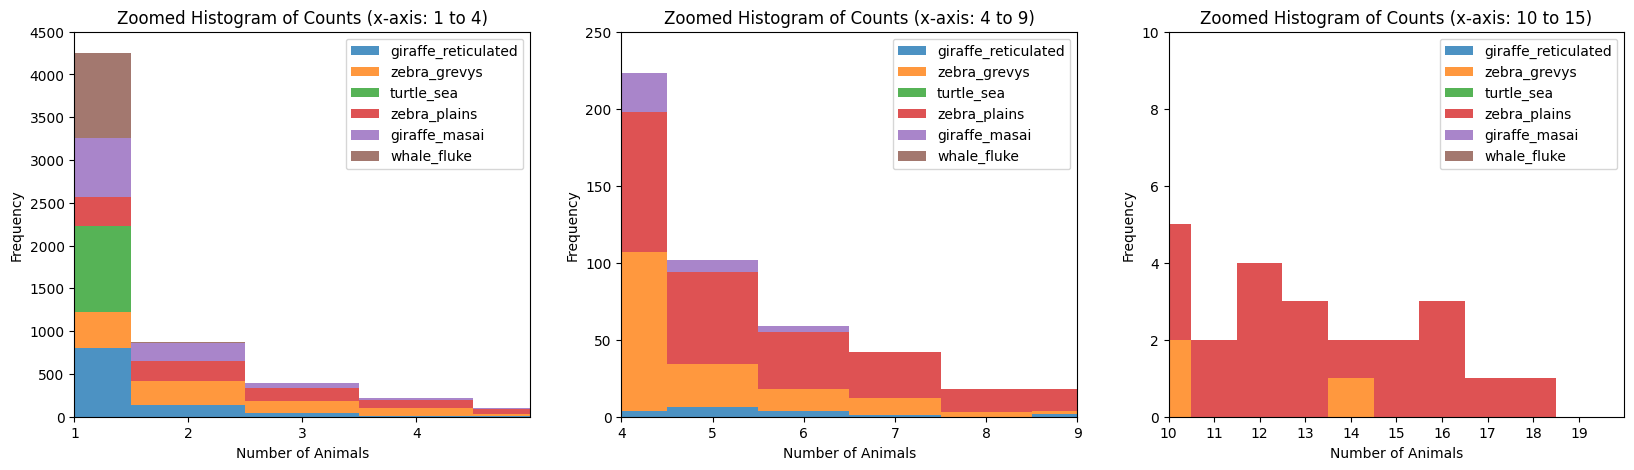

In [17]:
# Zoomed in plots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1
axs[0].hist(hist_data, bins=bins, alpha=0.8, label=reduced_classes, stacked=True)
axs[0].set_xlabel('Number of Animals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Zoomed Histogram of Counts (x-axis: 1 to 4)')
axs[0].set_xlim(1, 5)  # Adjust the range for the x-axis
axs[0].set_ylim(0, 4500)
axs[0].legend()
axs[0].set_xticks(range(1, 5))

# Plot 2
axs[1].hist(hist_data, bins=bins, alpha=0.8, label=reduced_classes, stacked=True)
axs[1].set_xlabel('Number of Animals')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Zoomed Histogram of Counts (x-axis: 4 to 9)')
axs[1].set_xlim(4, 9)  # Adjust the range for the x-axis
axs[1].set_ylim(0, 250)
axs[1].legend()
axs[1].set_xticks(range(4, 10))

# Plot 3
axs[2].hist(hist_data, bins=bins, alpha=0.8, label=reduced_classes, stacked=True)
axs[2].set_xlabel('Number of Animals')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Zoomed Histogram of Counts (x-axis: 10 to 15)')
axs[2].set_xlim(10, 20)  # Adjust the range for the x-axis
axs[2].set_ylim(0, 10)
axs[2].legend()
axs[2].set_xticks(range(10, 20))

plt.show()

To determine if any of the six species show up more frequently in the images, we also calculated the total count for each species and created a bar chart for better visualization.

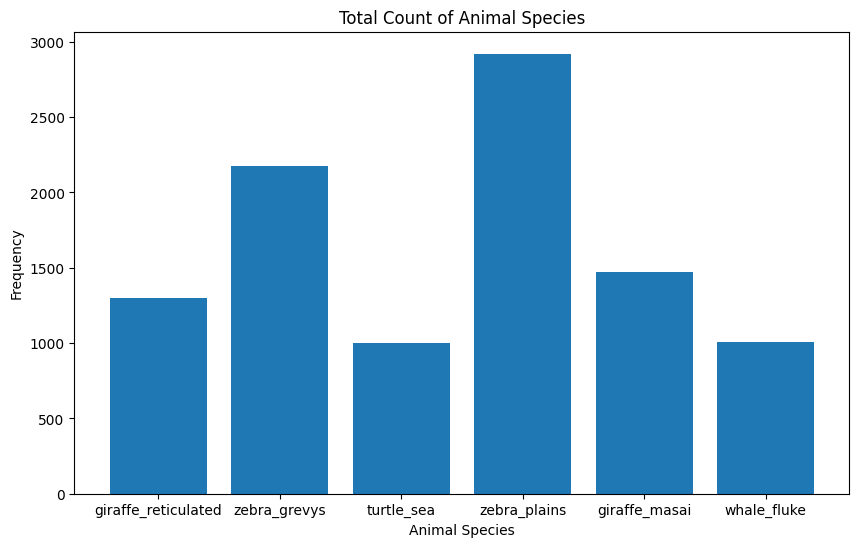

In [18]:
total_species_counts = {animal_class: sum(species_counts[animal_class]) for animal_class in reduced_classes}

plt.figure(figsize=(10, 6))
plt.bar(total_species_counts.keys(), total_species_counts.values())
plt.xlabel('Animal Species')
plt.ylabel('Frequency')
plt.title('Total Count of Animal Species')
plt.show()

**Among the 6 animals that we were interested in, we found that plains zebras show up more frequently than other species in the images.**

## **Question 2. Build the custom datasets object**

In Chapter 8.7, we used the torchvision.datasets function/object to load the MNIST dataset into Python. For this project, we created a custom dataset that was not built into PyTorch.

In [19]:
# Install opencv for cv2:
!pip install opencv-python

We installed the OpenCV library and defined a custom Dataset-class object.

The custom dataset read images from the JPEGImages folder, resized them to a specified size, normalized pixel values, linked the images with corresponding labels from .npy files created previously, and divided the images for training, validation, and testing using IDs provided in train.txt, val.txt, and test.txt in the Imagesets/Main folder.

We used the read_csv() function from pandas instead of the glob() function mentioned in the tutorial.

In [24]:
# Class to create the dataset
class ClassifyCountDataset(Dataset):
    def __init__(self, dataset_type, img_size):
        self.img_path = jpeg_path
        self.classify_path = class_annotations_path
        self.count_path = count_annotations_path

        # Transform the image using the mean and standard deviation of the training data
        train_mean, train_sd = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
        self.transforms = transforms.Compose(
            [
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(train_mean, train_sd)
            ]
        )
        self.files = pd.read_csv(os.path.join('/content/drive/MyDrive/Old school work/SML 301/wild/ImageSets/Main',
                                             '{}.txt'.format(dataset_type)), header=None)[0].tolist()
    def __getitem__(self, index):
        file = self.files[index]
        img = self.transforms(Image.fromarray(cv2.imread(os.path.join(self.img_path, file+'.jpg')).astype(np.uint8)))
        classify_target = torch.from_numpy(np.load(os.path.join(self.classify_path, file+'.npy')))
        count_target = torch.from_numpy(np.load(os.path.join(self.count_path, file+'.npy')))

        return img, classify_target, count_target

    def __len__(self):
        return len(self.files)

### **Questions about the `ClassifyCountDataset` class:**

*1) How is `self.files` is calculated?*

*2) Describe the values `self.files` stores when `dataset_type` is set to 'test', and provide a few examples of these values.*

*3) What steps did we take to make `img`?*

*4) What is `classify_target` and where it is from?*

**Answers:**

1.) The self.files variable is calculated by reading a text file whose name corresponds to the dataset type one seeks to use. The possible values for dataset_type are 'test', 'train', 'trainval', and 'val'. For example, if dataset_type is 'train', the text file read would be 'train.txt'. This file, which contains a list of image file names, are read into a pandas DataFrame and then converted into a list.

2.) When dataset_type is set to 'test', self.files stores a list of file names of images in the test dataset. These file names are extracted from the text file named 'test.txt' located in wild/ImageSets/Main. Each entry in the list self.files corresponds to a test image file without the '.jpg' extension. For example, values might look something like this: 'img001', 'img002', 'img003' → which would correspond to image files named 'img001.jpg', 'img002.jpg', 'img003.jpg', and so on.

3.) img begins with the jpeg file that is read in using opencv2.imread(). This is then transformed into a rescaled numerical format to be used as input for Image.fromarray, which changes the format of the image to PIL. From there the image is transformed so that the images are resized and changed to tensors, and the pixels are normalized using the mean and standard deviation values of trean_mean and train_sd.

4.) classify_target is a PyTorch tensor of 0s and 1s that contains the classification labels/annotations indicating the class or species of the animal(s) present in a specific image.  It is created by loading the NumPy array file corresponding to the image from the self.classify_path directory and then converting the NumPy array to a PyTorch tensor using torch.from_numpy().

## **Question 3. Model architecture**

We defined a convolutional neural network (CNN) that predicts the animals shown on a image, as well as the counts for each animal. Because our CNN is supposed to produce two different kinds of outputs (animal class identifications and animal counts for each class) our CNN was structured accordingly.

We read, "*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*" by Song and Qui. This gave us a better idea of the structure of the network that we sought to build. Our CNN had an architecture similar to the network in the paper but was simpler. Following similar steps as the ones in the paper, we built a CNN that had 2 output branches. Just as the method described in the paper, we trained the upstream layers jointly. However, instead of using the famous VGG-16 network architecture for the upstream layers, we only borrowed the architecture of the first few layers of VGG-16. This was because VGG-16 has approximately 138 million hyperparameters, and it would have taken a long time to train the entire VGG-16.

The code in the next cell provided partial code for building the network for this project. We filled in the parts labeled with "..." to complete the code. We assumed that the input images were of size 128 x 128.

We used the torch.nn.BatchNorm2d() function to do batch normalization and kept the default values for its input. Batch normalization is a popular technique used for improving deep neural network performance.
Just a reminder: The `nn.Sequential()` function was discussed in Chapter 8.5 of the lecture notes.


--


We have described the architecture of the network below:

For **block 1**:

* first layer:
    + a convolutional layer with 64 channels with (5 x 5) filters (kernels) with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 64 channels with (5 x 5) filters; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For **block 2**:

* first layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (5 x 5) filters with no padding; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding


For each of the **branches**

The following two layers are coded with the *self.branches.append()* function

* first layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.

* second layer:
    + a convolutional layer with 128 channels with (3 x 3) filters with one row/column of zeros added to all four sides of the input; batch normalization; activation function: relu.
    + a maximum pooling layer with (2 x 2 filter), each time move the filter 2 steps when moving horizontally and vertically, no padding

Third layer: flatten

The following layers are coded with the *self.outputs.append()* function


* fourth layer:
    + dense layer with 256 neurons; activation function: relu
    + dropout rate: 50%

    
* output layer.

In [21]:
# Neural network class
class VGG16Counting(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16Counting, self).__init__()

        # Block 1
        self.block1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.Conv2d(64, 64, kernel_size=5),
                                     nn.BatchNorm2d(64),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2, stride=2))

        # Block 2
        self.block2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=5),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.Conv2d(128, 128, kernel_size=5),
                                     nn.BatchNorm2d(128),
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2, stride=2))

        # Branches
        self.branches, self.outputs = nn.ModuleList(), nn.ModuleList()
        for _ in range(2):
            self.branches.append(nn.Sequential(nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(128),
                                               nn.ReLU(),
                                               nn.Conv2d(128, 128, kernel_size=3, padding=1),
                                               nn.BatchNorm2d(128),
                                               nn.ReLU(),
                                               nn.MaxPool2d(kernel_size=2, stride=2),
                                               nn.Flatten()))
            # Outputs
            self.outputs.append(nn.Sequential(nn.Linear(2 * 128 * 13 * 13, 256),
                                              nn.ReLU(),
                                              nn.Dropout(p=0.5),
                                              nn.Linear(256, num_classes)
                                              ))

    def forward(self, x):
        x = self.block2(self.block1(x))
        x = torch.cat([torch.flatten(branch(x), start_dim=1) for branch in self.branches], 1)
        outputs = [output(x) for output in self.outputs]

        return outputs

## **Question 4. Model training**

### Part a

In this part of the question, we defined the train() function for training the model.

In [36]:
# Training function
from sklearn.metrics import multilabel_confusion_matrix, mean_squared_error

def train(model, optimizer, train_dataloader, val_dataloader, num_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Define MSE and BCE loss functions
    mse_criterion = nn.MSELoss()
    bce_criterion = nn.BCEWithLogitsLoss()

    # Initialize lists to store train and validation losses
    train_losses, val_losses = [], [] #  Added for monitoring overfitting

    # Loop over epochs
    for epoch in range(1, num_epochs + 1):
        # Set model to training mode
        model.train()
        # Initialize train loss
        train_loss = 0

        # Loop over batches in train dataloader
        for batch_i, (imgs, targets_classify, targets_counts) in enumerate(train_dataloader):
            imgs, targets_classify, targets_counts = imgs.to(device), targets_classify.to(device).float(), targets_counts.to(device).float()
            outputs = model(imgs)
            bce_loss = bce_criterion(outputs[0], targets_classify)
            mse_loss = mse_criterion(outputs[1], targets_counts)
            loss = bce_loss + mse_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add loss to train_loss
            train_loss += loss.item() # Added for monitoring overfitting

        # Calculate average train loss
        train_losses.append(train_loss / len(train_dataloader)) # Added for monitoring overfitting

        # Set model to evaluation mode for validation
        model.eval()
        # Initialize tensors to store targets and predictions
        total_targets_classify = torch.Tensor().to(device)
        total_targets_count = torch.Tensor().to(device)
        total_preds_classify = torch.Tensor().to(device)
        total_preds_count = torch.Tensor().to(device)

        # Define sigmoid activation function
        sigmoid_activation = nn.Sigmoid()

        # Initialize validation loss
        val_loss = 0 # Added for monitoring overfitting
        with torch.no_grad():
            for batch_i, (imgs, targets_classify, targets_counts) in enumerate(val_dataloader):
                imgs, targets_classify, targets_counts = imgs.to(device), targets_classify.to(device).int(), targets_counts.to(device).int()
                outputs = model(imgs)

                # Calculate BCE and MSE loss
                bce_loss = bce_criterion(outputs[0], targets_classify.float())
                mse_loss = mse_criterion(outputs[1], targets_counts.float())
                loss = bce_loss + mse_loss # Modified for monitoring overfitting
                val_loss += loss.item() # Added for monitoring overfitting

                # Concatenate predictions and targets
                total_preds_classify = torch.cat((total_preds_classify, torch.round(sigmoid_activation(outputs[0])).int()), dim=0)
                total_targets_classify = torch.cat((total_targets_classify, targets_classify), dim=0)

                total_targets_count = torch.cat((total_targets_count, targets_counts.float()), dim=0)
                total_preds_count = torch.cat((total_preds_count, torch.round(nn.ReLU()(outputs[1])).int()), dim=0)

        # Calculate average validation loss
        val_losses.append(val_loss / len(val_dataloader)) # Added for monitoring overfitting

        # Calculate confusion matrix and classwise precision for classification task
        confusion_matrix = multilabel_confusion_matrix(total_targets_classify.cpu().detach().numpy(),
                                                       total_preds_classify.cpu().detach().numpy())

        # Calculate precisions
        classwise_precisions = []
        for i in range(6):
            tp = confusion_matrix[i][1][1]
            fp = confusion_matrix[i][0][1]
            precision = tp / (tp + fp)
            classwise_precisions.append(precision)

        print("Average precision for each class>>", classwise_precisions)

        # Calculate relative root mean squared error
        relrmse_classwise = []
        total_targets_count_arr = total_targets_count.cpu().detach().numpy()
        total_preds_count_arr = total_preds_count.cpu().detach().numpy()
        for i in range(6):
            mse = mean_squared_error(total_targets_count_arr[:, i], total_preds_count_arr[:, i])
            mean = total_targets_count_arr[:, i].mean()
            rel = ((total_targets_count_arr[:, i] - mean) ** 2).mean()
            relrmse = (mse ** 0.5) / (rel ** 0.5)
            relrmse_classwise.append(relrmse)


        print("Mean relative Root mean squared error>>", sum(relrmse_classwise) / len(relrmse_classwise))


        # Added for monitoring overfitting
        print(f'Epoch {epoch}: train loss {train_losses[-1]:.4f}, validation loss {val_losses[-1]:.4f}')

    # Save the losses to a file
    with open('losses.pkl', 'wb') as f:
        pickle.dump({'train_losses': train_losses, 'val_losses': val_losses}, f)

    return train_losses, val_losses

### Part b

Note that the loss function is defined to be the sum of two loss functions: `MSELoss()` and `BCEWithLogitsLoss()`.  This is inspired by the loss function used in the paper by Song and Qui.

**Justify why it is reasonable to use the two loss functions `MSELoss()` and `BCEWithLogitsLoss()`.**

In our situation, it is reasonable to use a combination of `MSELoss()` and `BCEWithLogitsLoss()` as the loss function because the problem involves solving two tasks: classification and regression.

For the classification task, we use BCEWithLogitsLoss() to predict the presence/absence of each animal class in an image. This loss function is appropriate for multi-label classification problems and handles sigmoid activation and binary cross-entropy calculations.

For the regression task, we use MSELoss() to predict the counts of each animal class in an image. This loss function measures the average squared difference between the predicted and actual counts, which is commonly used for regression problems.

Thus, by summing up the two loss functions, the model is enabled to optimize both classification and regression tasks at the same time.


### Part c

Note that the use of `BCEWithLogitsLoss()` (instead of `nn.CrossEntropyLoss()`) means that we use the sigmoid function (instead of a softmax function) as the activation function for the last layer for the classification branch.  

However, there are 6 neurons in the output layer for the classification branch, one for each class.  For the examples that we have seen in this course, usually when there are more than 2 classes, we use a softmax function on the last layer, and only use the sigmoid function for binary classification.  Explain why the use of the sigmoid function is appropriate here.

#### **Answer:**

The use of the sigmoid function is appropriate because the problem we are dealing with is a *multi-label* rather than a *multi-class* classification. In a multi-class classification problem, there is an implication there is a mutually exclusive relationship between the classes—which is not true in our case.

To answer the hint: if we applied the softmax function to the values 𝑧1, 𝑧2, ..., 𝑧6 → values after the softmax transformation would sum up to 1. Then, the implied relationship between the classes would be competition or mutual exclusivity. This is not what we want in a multi-label classification problem.

In our specific situation, we want to predict the probability of each of 6 classes/animal species independently. Thus, using the sigmoid function allows us to model the probability of each class being present or absent in the input, without forcing all the probabilities to sum up to 1.


### Part d
The dataset_type parameter is set to 'train' for the training dataset and 'val' for the validation dataset, and the img_size is set to 128, as specified in the problem description.

In [37]:
# Create dataloader
train_dataset = ClassifyCountDataset(dataset_type='train', img_size=128)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = ClassifyCountDataset(dataset_type='val', img_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

We initiate the model and define the optimizer below.

In [38]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = VGG16Counting(num_classes=6).to(device)

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 30

### Part e

We trained the model and made sure that our champion model did not overfit by using the validation set to monitor the performance of the model during training. We trained thirty epochs.

In [39]:
torch.manual_seed(2023)

# Train the model
train_losses, val_losses = train(model, optimizer,
                                 train_dataloader, val_dataloader,
                                 num_epochs=num_epochs)

Average precision for each class>> [0.8166666666666667, 0.7922077922077922, 0.9938650306748467, 0.9473684210526315, 0.5602836879432624, 0.9217877094972067]
Mean relative Root mean squared error>> 1.053720191843394
Epoch 1: train loss 1.2502, validation loss 1.0602
Average precision for each class>> [0.708994708994709, 0.7438423645320197, 0.9783783783783784, 0.9017857142857143, 0.711864406779661, 0.863849765258216]
Mean relative Root mean squared error>> 1.0495423933790973
Epoch 2: train loss 0.9578, validation loss 1.0062
Average precision for each class>> [0.9186991869918699, 0.875, 0.9837837837837838, 0.9032258064516129, 0.5017543859649123, 0.893719806763285]
Mean relative Root mean squared error>> 1.0435981751740593
Epoch 3: train loss 0.9137, validation loss 0.9831
Average precision for each class>> [0.8835616438356164, 0.803030303030303, 0.9943502824858758, 0.7229437229437229, 0.7428571428571429, 0.9033816425120773]
Mean relative Root mean squared error>> 1.0001977499475816
Epoch 

We provided graphs to show that we did not overfit our model.

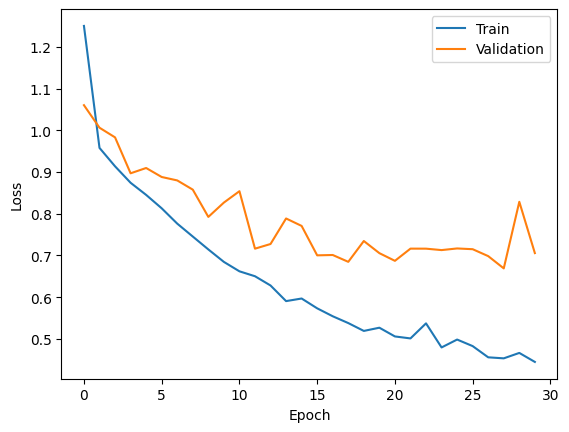

In [40]:
# Plot the training and validation losses
with open('losses.pkl', 'rb') as f:
    losses = pickle.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Part f

Finally, we used our champion model to evaluate on the test set and reported AUC for each animal species.

In [41]:
# Load the test data
test_dataset = ClassifyCountDataset(dataset_type = 'test', img_size = 128)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [42]:
# Run the model on the test data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize loss functions for multi-class classification and regression tasks
mse_criterion = nn.MSELoss()
bce_criterion = nn.BCEWithLogitsLoss()

# Set the model to evaluation mode
model.eval()

# Initialize empty tensors to hold the predicted and true labels
total_targets_classify = torch.Tensor().to(device)
total_targets_count = torch.Tensor().to(device)
total_preds_classify = torch.Tensor().to(device)
total_preds_count = torch.Tensor().to(device)

# Define the sigmoid activation function
sigmoid_activation = nn.Sigmoid()

test_loss = 0
with torch.no_grad():
  # Loop through the testing data in batches
  for batch_i, (imgs, targets_classify, targets_counts) in enumerate(test_dataloader):
    imgs, targets_classify, targets_counts = imgs.to(device), targets_classify.to(device).int(), targets_counts.to(device).int()
    outputs = model(imgs)

    bce_loss = bce_criterion(outputs[0], targets_classify.float())
    mse_loss = mse_criterion(outputs[1], targets_counts.float())
    loss = bce_loss + mse_loss # Modified for monitoring overfitting
    test_loss += loss.item() # Added for monitoring overfitting

    total_preds_classify = torch.cat((total_preds_classify, torch.round(sigmoid_activation(outputs[0])).int()), dim=0)
    total_targets_classify = torch.cat((total_targets_classify, targets_classify), dim=0)

    total_targets_count = torch.cat((total_targets_count, targets_counts.float()), dim=0)
    total_preds_count = torch.cat((total_preds_count, torch.round(nn.ReLU()(outputs[1])).int()), dim=0)

# Compute the confusion matrix to evaluate the classification performance
confusion_matrix = multilabel_confusion_matrix(total_targets_classify.cpu().detach().numpy(),
                                                      total_preds_classify.cpu().detach().numpy())

# Calculate the average precision for each class
classwise_precisions = []
for i in range(6):
  tp = confusion_matrix[i][1][1]
  fp = confusion_matrix[i][0][1]
  precision = tp / (tp + fp)
  classwise_precisions.append(precision)

print("Average precision for each class>>", classwise_precisions)

# Calculate the mean relative root mean squared error for the regression task
relrmse_classwise = []
total_targets_count_arr = total_targets_count.cpu().detach().numpy()
total_preds_count_arr = total_preds_count.cpu().detach().numpy()
for i in range(6):
  mse = mean_squared_error(total_targets_count_arr[:, i], total_preds_count_arr[:, i])
  mean = total_targets_count_arr[:, i].mean()
  rel = ((total_targets_count_arr[:, i] - mean) ** 2).mean()
  relrmse = (mse ** 0.5) / (rel ** 0.5)
  relrmse_classwise.append(relrmse)


print("Mean relative Root mean squared error>>", sum(relrmse_classwise) / len(relrmse_classwise))

Average precision for each class>> [0.9716312056737588, 0.8963730569948186, 0.9798994974874372, 0.8472906403940886, 0.759656652360515, 0.9848484848484849]
Mean relative Root mean squared error>> 0.9841316540846824


In [43]:
# convert classification predictions and targets to numpy arrays
total_targets_classify_arr = total_targets_classify.cpu().detach().numpy()
total_preds_classify_arr = total_preds_classify.cpu().detach().numpy()

In [44]:
from sklearn.metrics import roc_auc_score

# get AUC for each class/animal species
for i in range(len(reduced_classes)):
  print(reduced_classes[i], ": ", roc_auc_score(total_targets_classify_arr[:, i], total_preds_classify_arr[:, i]))

giraffe_reticulated :  0.8404188345473466
zebra_grevys :  0.9449644967206895
turtle_sea :  0.9829912935323383
zebra_plains :  0.8874056575741369
giraffe_masai :  0.898186127062255
whale_fluke :  0.9859391259105099


The AUC for each animal species was:
- giraffe_reticulated : 0.8404188345473466
- zebra_grevys : 0.9449644967206895
- turtle_sea : 0.9829912935323383
- zebra_plains : 0.8874056575741369
- giraffe_masai : 0.898186127062255
- whale_fluke : 0.9859391259105099

### **Honor Code**
I pledge my honor that I have not violated the honor code when completing this assignment.

Digitally signed: *Melissa Chun* and *Annika Hsi*
